**Napisz algorytm prognozujący pogodę używając do tego techniki expanding window.**

Zbiór danych:

Plik CSV Temp_K_PL.csv

kolumny: [time, median, 1st quartile, 3rd quartile, std, skew, kurt, name, ISO]
zbiór zawiera medianę odczytów temperatury powietrza w Polsce w latach 2016 - 2021, dane są samplowane w tygodniowych odstępach

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

In [19]:
TEMP = '/content/drive/MyDrive/DataScience/data/Temp_K_PL.csv'

In [20]:
# czytanie csv
df = pd.read_csv(TEMP, index_col='time')

In [21]:
# przekształcanie typu danych indeksu na datetime
df.index = pd.to_datetime(df.index)

In [22]:
df.head()

,median,1st qurtile,3rd quartile,std,skew,kurt,name,ISO
time,,,,,,,,
2016-01-03,264.716677,262.921959,265.852616,1.889447,-0.059618,-0.554926,Poland,PL
2016-01-10,268.711015,267.183356,270.844637,2.221273,0.123174,-0.530078,Poland,PL
2016-01-17,273.267683,271.830870,274.496929,1.814086,-0.132401,-0.610430,Poland,PL
2016-01-24,269.937119,268.639463,271.130552,1.712920,-0.493850,-0.223058,Poland,PL
2016-01-31,278.927229,277.705730,280.178840,1.730251,-0.129186,0.070476,Poland,PL


In [23]:
# ustawianie częstotliwości na tygodniową
df.index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='W')

In [24]:
df.head()

,median,1st qurtile,3rd quartile,std,skew,kurt,name,ISO
2016-01-03,264.716677,262.921959,265.852616,1.889447,-0.059618,-0.554926,Poland,PL
2016-01-10,268.711015,267.183356,270.844637,2.221273,0.123174,-0.530078,Poland,PL
2016-01-17,273.267683,271.830870,274.496929,1.814086,-0.132401,-0.610430,Poland,PL
2016-01-24,269.937119,268.639463,271.130552,1.712920,-0.493850,-0.223058,Poland,PL
2016-01-31,278.927229,277.705730,280.178840,1.730251,-0.129186,0.070476,Poland,PL


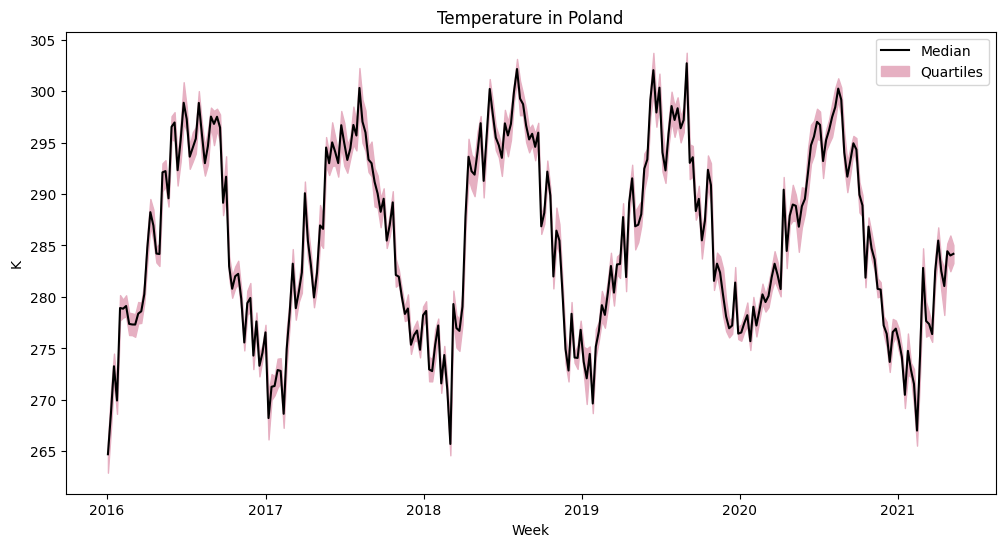

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['median'], color='black', label='Median')
plt.fill_between(df.index, df['1st qurtile'], df['3rd quartile'], color='#e6b0c2', label='Quartiles')
plt.title('Temperature in Poland')
plt.legend()
plt.xlabel('Week')
plt.ylabel('K')
plt.show()

In [26]:
# wybór z ramki szeregu median

series_median = df['median']
series_median

2016-01-03    264.716677
2016-01-10    268.711015
2016-01-17    273.267683
2016-01-24    269.937119
2016-01-31    278.927229
                 ...    
2021-04-11    282.520759
2021-04-18    281.059609
2021-04-25    284.440164
2021-05-02    284.030293
2021-05-09    284.188453
Freq: W-SUN, Name: median, Length: 280, dtype: float64

In [27]:
# wydzielenie z szeregu zbioru treningowego i testowego

train = series_median[:'2019']
test = series_median['2020':]

In [28]:
model = ExponentialSmoothing(train, trend='add')

In [29]:
train_r = train.reindex(
    pd.date_range(
        start=train.index[0],
        end='2019-12-31',
        freq='W'
    )
)

In [30]:
# uzupełnianie, jakby były nulle
train_r = train_r.fillna(method='ffill')

In [31]:
train_r.tail(10)

2019-10-27    290.866098
2019-11-03    281.561130
2019-11-10    283.236132
2019-11-17    282.383210
2019-11-24    280.168827
2019-12-01    278.107780
2019-12-08    276.956372
2019-12-15    277.226208
2019-12-22    281.398000
2019-12-29    276.435701
Freq: W-SUN, Name: median, dtype: float64

<Figure size 1800x600 with 0 Axes>

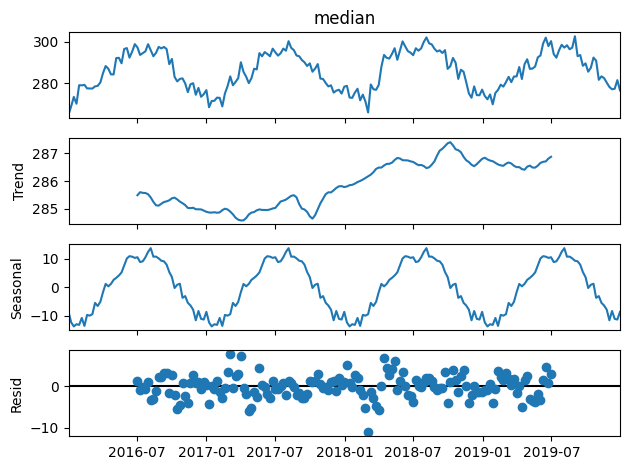

In [32]:
res = seasonal_decompose(train_r)
plt.figure(figsize=(18, 6))
res.plot();

In [33]:
test_r = test.reindex(
    pd.date_range(
        start='2020-01-01',
        end=test.index[-1],
        freq='W'
    )
)

# na wypadek nulli
test_r.fillna(method='ffill', inplace=True)
test_r.fillna(method='bfill', inplace=True)

In [34]:
model_es = ExponentialSmoothing(
    train_r,
    trend = 'add',
    seasonal='add',
    seasonal_periods=52
)

In [35]:
model_es = model_es.fit()

In [36]:
fes = model_es.forecast(5)

In [37]:
# Sprawdź wyniki modelu używając metryk z zajęć (Forecast Bias, Mean Squared Error).

In [38]:
def forecast_bias(y, yi):
  # kierunek błędu
  fb = (y-yi).mean()
  return fb

In [39]:
forecast_bias(test_r[:5], fes)


2.4157489091913247

In [40]:
np.sqrt(mean_squared_error(test_r[:5], fes))

2.8959648538487044

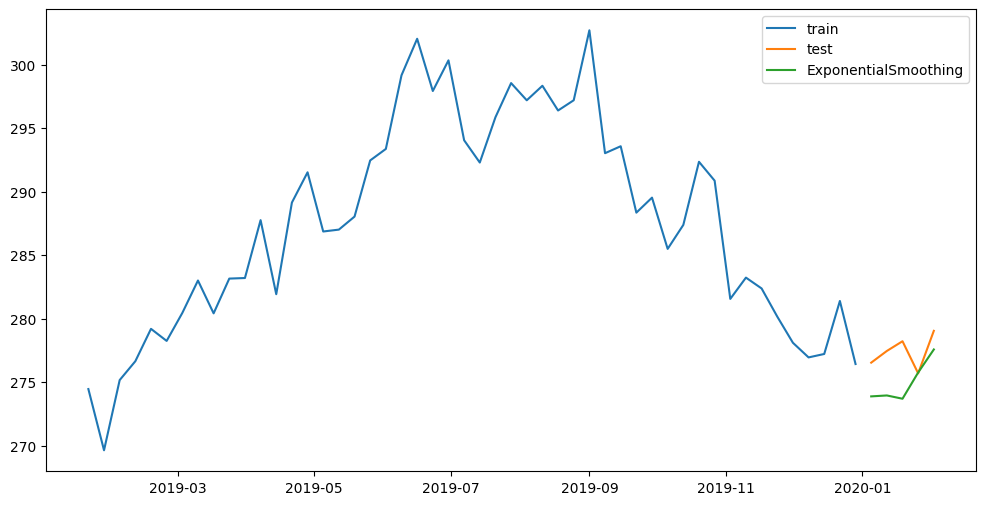

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(train_r[-50:])
plt.plot(test_r[:5])
plt.plot(fes)
plt.legend([
    'train', 'test', 'ExponentialSmoothing'
])
plt.show()

In [42]:
len(test_r)

71

In [43]:
train_r.iloc[208]

276.43570139938186

In [44]:
results = []
train_length = len(train_r)+1

for i in range(train_length, len(train_r) + len(test_r) - 4):
    # powiększanie danych treningowych o 1 rekord tygodniowo
    current_train_data = series_median[:i]

    # model na aktualnych danych treningowych
    model_es = ExponentialSmoothing(
        current_train_data,
        trend='add',
        seasonal='add',
        seasonal_periods=52,
    )

    model_es_fit = model_es.fit()
    forecast_values = model_es_fit.forecast(5)

    # wartości z testowego zbioru
    true_values = series_median[i:i+5]

    rmse = np.sqrt(mean_squared_error(true_values, forecast_values))

    # zapis
    result_entry = [len(current_train_data), current_train_data.index[-1], rmse]
    results.append(result_entry)

#for entry in results:
    #print(entry)

In [45]:
resdf = pd.DataFrame(data=results, columns=['tset len', 'date', 'MSE']).set_index('date')

In [46]:
resdf.head()

,tset len,MSE
date,,
2020-01-05,210,2.703161
2020-01-12,211,2.189978
2020-01-19,212,1.337916
2020-01-26,213,1.419948
2020-02-02,214,1.462331


In [47]:
resdf.index = pd.to_datetime(resdf.index)

In [48]:
resdf.head()

,tset len,MSE
date,,
2020-01-05,210,2.703161
2020-01-12,211,2.189978
2020-01-19,212,1.337916
2020-01-26,213,1.419948
2020-02-02,214,1.462331


In [49]:
resdf = resdf.sort_index()

In [50]:
resdf.head()

,tset len,MSE
date,,
2020-01-05,210,2.703161
2020-01-12,211,2.189978
2020-01-19,212,1.337916
2020-01-26,213,1.419948
2020-02-02,214,1.462331


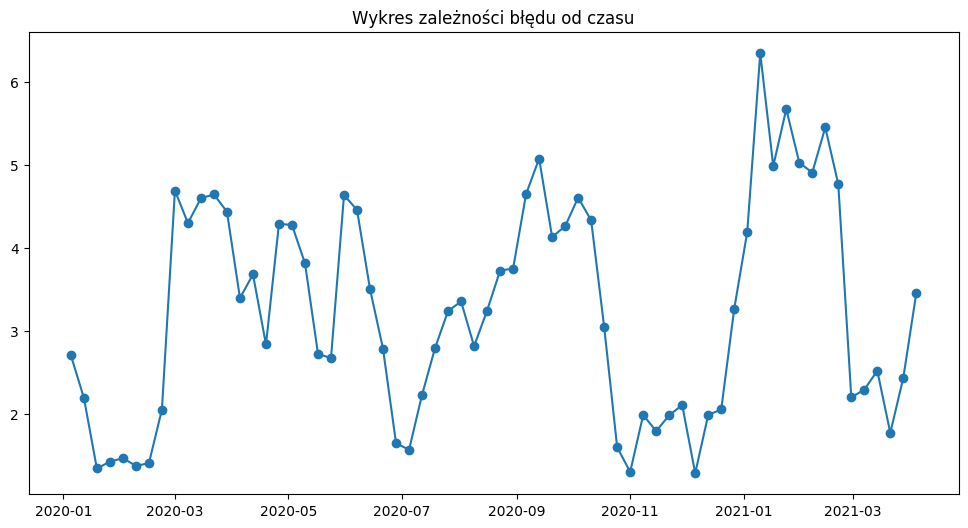

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(resdf.index, resdf['MSE'], marker='o', linestyle='-')
plt.title('Wykres zależności błędu od czasu')
plt.show()

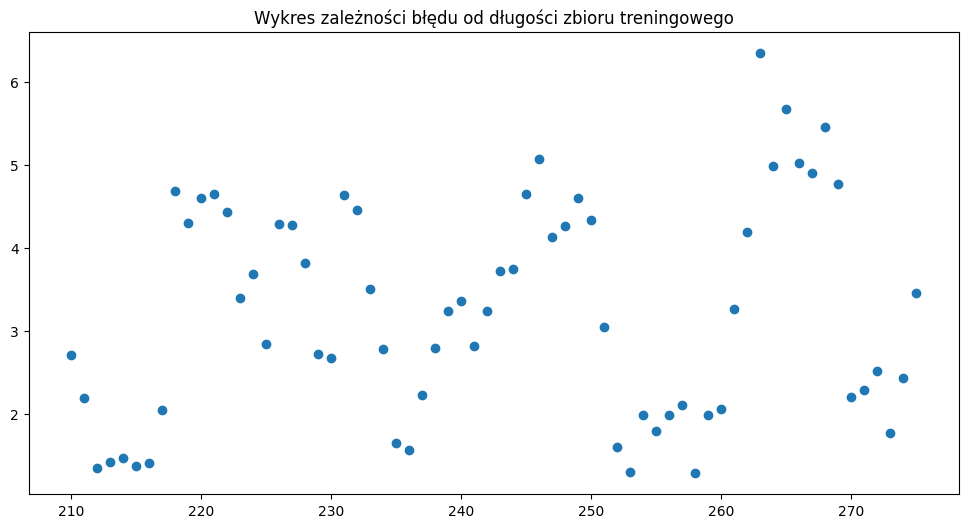

In [52]:
plt.figure(figsize=(12, 6))
plt.scatter(resdf['tset len'], resdf['MSE'], marker='o')
plt.title('Wykres zależności błędu od długości zbioru treningowego')
plt.show()

błąd był mały na samym początku, ale później zaczął rosnąć w czasie, eksperymentowanie z parametrami modelu się nie powiodło - model nie był przez to bardziej dopasowany

**END**